<img src="https://www.escoladnc.com.br/wp-content/uploads/2022/06/dnc_formacao_dados_logo_principal_preto-1.svg" alt="drawing" width="300"/>

# Recomendação com SVD (_Singular Value Decomposition_)

Neste notebook iremos explorar o `FunkSVD`, um algoritmo de fatoração de matrizes que ficou famoso no [Netflix Prize Challenge](https://www.thrillist.com/entertainment/nation/the-netflix-prize) (2006). Caso queira explorar a implementação do algoritmo, acesse [este repositório](https://github.com/gbolmier/funk-svd).

**Nota**: Para instalar a biblioteca `funk_svd` descomente a linha abaixo e execute a célula.

In [10]:
# !pip install git+https://github.com/gbolmier/funk-svd

In [3]:
import os
import re
import pandas as pd
import numpy as np
from google.colab import files
from funk_svd import SVD
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler

matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#007efd', '#FFC000', '#303030'])

# Carregando o dataset

Neste exemplo prático utilizaremos o `MovieLens`, dataset que contém avaliações de usuários para filmes que foi explorado no módulo **01 - Introdução aos Sistemas de Recomendação**. Em particular, carregaremos os seguintes arquivos:

- `ratings.parquet`: avaliações dos usuários para filmes
- `movies.parquet`: metadados dos filmes

## Arquivo de avaliações dos usuários

Upload file `ratings.parquet`

In [4]:
%%time
_ = files.upload() # approx: 1min20s

Saving ratings.parquet to ratings.parquet
CPU times: user 1.18 s, sys: 138 ms, total: 1.32 s
Wall time: 1min 21s


In [5]:
df_ratings = pd.read_parquet('ratings.parquet')
df_ratings.tail()

,user_id,item_id,rating,timestamp
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569


## Arquivo de metadados dos itens

Upload file `movies.parquet`

In [7]:
%%time
_ = files.upload() # approx: 10s

Saving movies.parquet to movies.parquet
CPU times: user 128 ms, sys: 15.8 ms, total: 144 ms
Wall time: 8.23 s


In [11]:
def extract_year_from_title(title:str, regex='(\d{4})'):
    match = re.search(regex, title)
    return None if match is None else match.group()

def convert_genres_to_list(genres:str, separator='|'):
    return genres.split(separator)

df_items = pd.read_parquet('movies.parquet')
df_items['genres'] = df_items['genres'].apply(convert_genres_to_list)
df_items['year'] = df_items['title'].apply(extract_year_from_title)
df_items.set_index('item_id', inplace=True)
df_items.tail()

,title,genres,year
item_id,,,
3948,Meet the Parents (2000),[Comedy],2000
3949,Requiem for a Dream (2000),[Drama],2000
3950,Tigerland (2000),[Drama],2000
3951,Two Family House (2000),[Drama],2000
3952,"Contender, The (2000)","[Drama, Thriller]",2000


# Definindo datasets de treino e validação

Como o FunkSVD é um modelo de parâmetros treináveis, podemos separar o dataset em treino e validação para observar se o treinamento está com uma boa generalização.

Dada a natureza sequencial do consumo de filmes, iremos utilizar o campo `timestamp` para fazer a quebra entre treino e validação: os primeiros `train_size` registros serão utilizados como treino e o restante como teste.

Além disso, a biblioteca `funk_svd` requer os seguintes nomes de colunas:

- `u_id`: identificador do usuário
- `i_id`: identificador do item
- `rating`: _feedback_ do usuário

In [9]:
train_size = 0.8
df_ratings.sort_values(by='timestamp', inplace=True)
df_train_set, df_valid_set= np.split(df_ratings, [int(train_size * df_ratings.shape[0])])
df_train_set.rename({'user_id': 'u_id', 'item_id': 'i_id'}, axis = 1, inplace=True)
df_valid_set.rename({'user_id': 'u_id', 'item_id': 'i_id'}, axis = 1, inplace=True)
print ('Train size: ', df_train_set.shape)
print ('Valid size: ', df_valid_set.shape)

Train size:  (800167, 4)
Valid size:  (200042, 4)


# Treinando o modelo

Para este exemplo prático iremos utilizar hiperparâmetros já explorados na literatura para o dataset do MovieLens. No entanto, para outros datasets é preciso que haja uma busca de hiperparâmetros que seja ideal para os dados em questão. Para ler a definição dos hiperparâmetros, consulte a [documentação](https://github.com/gbolmier/funk-svd/blob/master/funk_svd/svd.py).

**Nota**: para ler mais sobre testagem de hiperparâmetros, consulte a biblioteca [HyperOpt](http://hyperopt.github.io/hyperopt/).

In [13]:
model = SVD(
    lr=0.001, # Learning rate.
    reg=0.005, # L2 regularization factor.
    n_epochs=100, # Number of SGD iterations.
    n_factors=30, # Number of latent factors.
    early_stopping=True, # Whether or not to stop training based on a validation monitoring.
    min_delta=0.0001, # Minimun delta to argue for an improvement.
    shuffle=False, # Whether or not to shuffle the training set before each epoch.
    min_rating=1, # Minimum value a rating should be clipped to at inference time.
    max_rating=5 # Maximum value a rating should be clipped to at inference time.
)
model

Treinando o modelo

In [14]:
model.fit(X=df_train_set, X_val=df_valid_set)

Preprocessing data...

Preprocessing data...

Epoch 1/100  | val_loss: 1.06 - val_rmse: 1.03 - val_mae: 0.84 - took 1.3 sec
Epoch 2/100  | val_loss: 1.01 - val_rmse: 1.00 - val_mae: 0.81 - took 0.1 sec
Epoch 3/100  | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.79 - took 0.1 sec
Epoch 4/100  | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.78 - took 0.1 sec
Epoch 5/100  | val_loss: 0.95 - val_rmse: 0.98 - val_mae: 0.77 - took 0.1 sec
Epoch 6/100  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.77 - took 0.1 sec
Epoch 7/100  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.77 - took 0.1 sec
Epoch 8/100  | val_loss: 0.93 - val_rmse: 0.97 - val_mae: 0.76 - took 0.1 sec
Epoch 9/100  | val_loss: 0.93 - val_rmse: 0.96 - val_mae: 0.76 - took 0.1 sec
Epoch 10/100 | val_loss: 0.93 - val_rmse: 0.96 - val_mae: 0.76 - took 0.1 sec
Epoch 11/100 | val_loss: 0.92 - val_rmse: 0.96 - val_mae: 0.76 - took 0.1 sec
Epoch 12/100 | val_loss: 0.92 - val_rmse: 0.96 - val_mae: 0.76 - took 0.1 sec
Epoch 13/100 | val

# Avaliando o treinamento

Para validar se houve _overfitting_ ou _underfitting_ podemos plotar a evolução das métricas de treinamento e validação. Em particular, a biblioteca `funk_svd` nos fornece 3 métricas de treinamento:

- `Loss`: _Root Mean Squared Error_ (RMSE) a ser otimizado
- `MAE`: _Mean Absolute Error_ (MAE) do conjunto de validação
- `RMSE` _Root Mean Squared Error_ do conjunto de validação

Extraindo métricas de treinamento

In [15]:
model.metrics_

,Loss,RMSE,MAE
0,1.060689,1.029897,0.835224
1,1.008324,1.004153,0.805468
2,0.981091,0.990500,0.789807
3,0.964239,0.981957,0.780257
4,0.952743,0.976085,0.773844
...,...,...,...
63,0.888712,0.942715,0.742533
64,0.888501,0.942603,0.742480
65,0.888311,0.942502,0.742437
66,0.888143,0.942413,0.742404


(<Figure size 1152x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f51b3b748b0>)

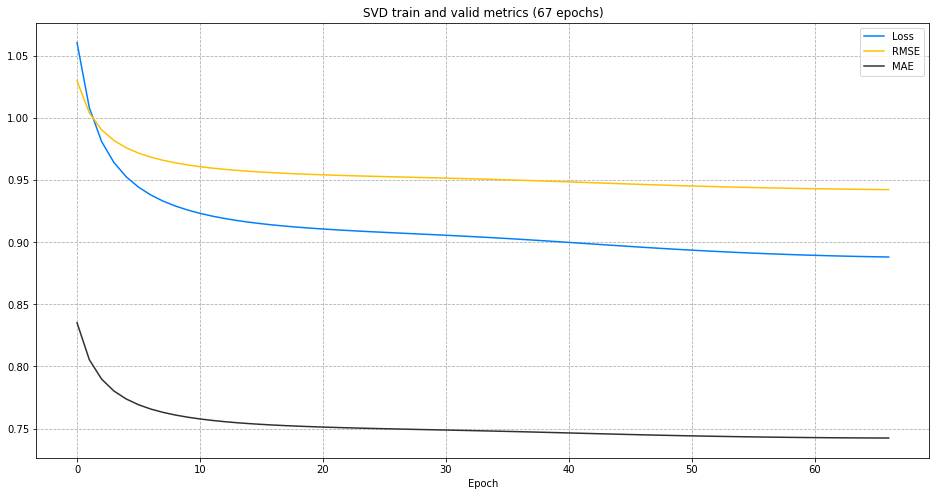

In [16]:
def plot_metrics_evolution(metrics:pd.DataFrame, figsize=(16,8)):
    fig, ax = plt.subplots(figsize=figsize)
    for metric_name in metrics.columns:
        ax.plot(metrics[metric_name], label=metric_name)
    ax.set_title(f'SVD train and valid metrics ({metrics.shape[0]} epochs)')
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.grid(True, linestyle='--')

    return fig, ax

plot_metrics_evolution(model.metrics_.head(-1))

Para prever as avaliações de usuários para itens, podemos utilizar o método `mode.predict()` para um batch de pares usuário-item:

In [17]:
df_valid_set['prediction'] = model.predict(df_valid_set)
df_valid_set.head()

,u_id,i_id,rating,timestamp,prediction
314160,1875,1721,4,975768738,3.747403
314032,1875,2621,4,975768748,3.539603
94555,635,3095,5,975768756,4.670989
94640,635,36,5,975768756,4.258718
94578,635,608,5,975768756,4.243185


Ou podemos fazer esta predição para um par de usuário-item específico utilizando o método `model.predict_pair()`:

In [18]:
item_id = 1721
user_id = 1875

In [19]:
def get_user_item_prediction(model, user_id, item_id):
    prediction = model.predict_pair(user_id, item_id)
    return prediction

prediction = get_user_item_prediction(model, user_id, item_id)
print (f'Prediction for user {user_id} to item {item_id}: {prediction}')
df_valid_set.query('u_id == @user_id and i_id == @item_id')

Prediction for user 1875 to item 1721: 3.747402619124449


,u_id,i_id,rating,timestamp,prediction
314160,1875,1721,4,975768738,3.747403


________________________

# Gerando recomendações

Uma vez que tenhamos o modelo treinado, podemos utilizar a função `recommend_n_items` abaixo que recebe:

- `model`: modelo FunkSVD treinado
- `user_id`: identificador do usuário que receberá as recomendações
- `item_ids`: identificadores dos itens no catálogo passíveis de recomendação
- `n`: número de recomendações a serem geradas

In [23]:
def recommend_n_items(model, user_id, item_ids:np.array, n=20):
    df_predictions = pd.DataFrame()
    df_predictions['i_id'] = item_ids
    df_predictions['u_id'] = user_id
    df_predictions['score'] = model.predict(df_predictions)

    user_predictions = (
        df_predictions
        .sort_values(by='score', ascending=False)
        .rename({'u_id': 'user_id', 'i_id': 'item_id'}, axis=1)
        .set_index('item_id')
    )

    return user_predictions.head(n)

item_ids = df_valid_set['i_id'].unique()
user_recommendations = recommend_n_items(model, user_id, item_ids, n=10)
user_recommendations

,user_id,score
item_id,,
1198,1875,4.751947
912,1875,4.670993
2019,1875,4.590326
2905,1875,4.576531
527,1875,4.574466
1148,1875,4.571462
260,1875,4.549448
34,1875,4.501998
1234,1875,4.479419


Anexando os metadados dos itens, obtemos:

In [24]:
user_recommendations.merge(df_items, left_index=True, right_index=True)

,user_id,score,title,genres,year
item_id,,,,,
1198,1875,4.751947,Raiders of the Lost Ark (1981),"[Action, Adventure]",1981
912,1875,4.670993,Casablanca (1942),"[Drama, Romance, War]",1942
2019,1875,4.590326,Seven Samurai (The Magnificent Seven) (Shichin...,"[Action, Drama]",1954
2905,1875,4.576531,Sanjuro (1962),"[Action, Adventure]",1962
527,1875,4.574466,Schindler's List (1993),"[Drama, War]",1993
1148,1875,4.571462,"Wrong Trousers, The (1993)","[Animation, Comedy]",1993
260,1875,4.549448,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Fantasy, Sci-Fi]",1977
34,1875,4.501998,Babe (1995),"[Children's, Comedy, Drama]",1995
1234,1875,4.479419,"Sting, The (1973)","[Comedy, Crime]",1973


Por fim, execute a célula abaixo diversas vezes para gerar recomendações de usuários aleatórios.

In [27]:
random_user_id = df_ratings['user_id'].sample().tolist()[0]
print (f'Recommendations for user {random_user_id}')
user_recommendations = recommend_n_items(model, random_user_id, item_ids, n=20)
user_recommendations.merge(df_items, left_index=True, right_index=True)

Recommendations for user 4815


,user_id,score,title,genres,year
item_id,,,,,
904,4815,5.0,Rear Window (1954),"[Mystery, Thriller]",1954
1260,4815,5.0,M (1931),"[Crime, Film-Noir, Thriller]",1931
2762,4815,5.0,"Sixth Sense, The (1999)",[Thriller],1999
326,4815,5.0,To Live (Huozhe) (1994),[Drama],1994
2905,4815,5.0,Sanjuro (1962),"[Action, Adventure]",1962
922,4815,5.0,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),[Film-Noir],1950
3030,4815,5.0,Yojimbo (1961),"[Comedy, Drama, Western]",1961
3949,4815,5.0,Requiem for a Dream (2000),[Drama],2000
3134,4815,5.0,"Grand Illusion (Grande illusion, La) (1937)","[Drama, War]",1937


__________________________

**Extra**: geração de resultados para avaliação das métricas no módulo 05

In [ ]:
from tqdm import tqdm
model_name = 'svd'
n = 20
catalog = df_items.index.values
df_recommendations = pd.DataFrame()
for user_id in tqdm(df_valid_set['u_id'].unique()):
  user_known_items = df_train_set.query('u_id == @user_id')['i_id'].unique()
  recommendable_items = np.array(list(set(catalog)-set(user_known_items)))
  user_recommendations = recommend_n_items(model, user_id, recommendable_items, n).reset_index(drop=False)
  user_recommendations['user_id'] = user_id
  df_recommendations = pd.concat([df_recommendations, user_recommendations])

df_recommendations['y_score'] = df_recommendations.apply(lambda x: {'item_id': x['item_id'], 'score': x['score']}, axis=1)
df_recommendations = df_recommendations.groupby('user_id').agg({'y_score': list}).reset_index(drop=False)
df_recommendations.tail()


,user_id,y_score
1778,6001,"[{'item_id': 858, 'score': 5.0}, {'item_id': 1..."
1779,6002,"[{'item_id': 913, 'score': 4.9074930024856425}..."
1780,6016,"[{'item_id': 1212, 'score': 4.3125449611992215..."
1781,6028,"[{'item_id': 2905, 'score': 4.447938905547112}..."
1782,6040,"[{'item_id': 1212, 'score': 4.694640815837579}..."


In [ ]:
df_predictions = df_valid_set.rename({'u_id': 'user_id', 'i_id': 'item_id'}, axis=1)
df_predictions['y_true'] = df_predictions.apply(lambda x: {'item_id': x['item_id'], 'rating': x['rating']}, axis=1)
df_predictions = df_predictions.groupby('user_id').agg({'y_true': list}).reset_index(drop=False)
df_predictions = df_predictions.merge(df_recommendations, on='user_id', how='inner')
df_predictions['model'] = model_name
df_predictions.tail()

,user_id,y_true,y_score,model
1778,6001,"[{'item_id': 3751, 'rating': 4}, {'item_id': 3...","[{'item_id': 858, 'score': 5.0}, {'item_id': 1...",svd
1779,6002,"[{'item_id': 1942, 'rating': 5}, {'item_id': 4...","[{'item_id': 913, 'score': 4.9074930024856425}...",svd
1780,6016,"[{'item_id': 3756, 'rating': 3}, {'item_id': 3...","[{'item_id': 1212, 'score': 4.3125449611992215...",svd
1781,6028,"[{'item_id': 3000, 'rating': 4}]","[{'item_id': 2905, 'score': 4.447938905547112}...",svd
1782,6040,"[{'item_id': 3182, 'rating': 5}, {'item_id': 2...","[{'item_id': 1212, 'score': 4.694640815837579}...",svd


In [ ]:
column_order = ['model', 'user_id', 'y_true', 'y_score']
df_predictions[column_order].to_parquet(f'valid_{model_name}.parquet', index=None)